In [1]:
from __future__ import print_function
import sys
sys.path.append('../build/')
%pylab inline
np.set_printoptions(precision=4, suppress=True)
import versor as vsr
import hyperdual
from versor.drawing import *

/Users/lars/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/lars/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
th = pi/6
B = vsr.EGA(vsr.Biv(1,0,0)) * np.tan(th/2)
B
one = vsr.EGA(1,0,0,0,0,0,0,0)

In [3]:
vsr.EGA(vsr.Vec(1,2,3)).spin((one + B) * (one - B).inv())

EGA: [ 0 2.2 0.13 3 0 0 0 0 ]

In [4]:
vsr.EGA(vsr.Vec(1,2,3)).spin(vsr.EGA(vsr.Biv(-th,0,0).exp()))

EGA: [ 0 2.2 0.13 3 0 0 0 0 ]

In [5]:
rotor = (vsr.Biv(1,0,0).unit() * (pi/6)).exp()

In [6]:
B = vsr.EGA(rotor.log())
B

EGA: [ 0 0 0 0 -0.52 0 0 0 ]

In [7]:
one = vsr.EGA(1,0,0,0,0,0,0,0)

In [8]:
R2 = (one + B) * (one - B).inv()
R2 * R2.rev()

EGA: [ 1 0 0 0 0 0 0 0 ]

In [9]:
M = vsr.Vec(1,2,3).trs() * rotor
M

Mot: [ 0.87 -0.5 0 0 -0.93 -0.62 -1.3 0.75 ]

In [10]:
Bm = M.log()
Bm

Dll: [ -0.5236 0 0 -0.977 -0.6451 -1.5 ]

In [11]:
MextE = (Bm ^ Bm) * 0.5 + Bm + 1

In [12]:
MextE * MextE.rev()

Mot: [ 1.3 0 0 0 0 0 -1.1e-16 0 ]

In [13]:
(Bm ^ Bm) ^ Bm

Mot: [ 0 0 0 0 0 0 0 0 ]

In [14]:
Bm = vsr.Mot(0,Bm[0],Bm[1],Bm[2],Bm[3],Bm[4],Bm[5],0)

In [15]:
def Cayley(B):
    one = onem = vsr.Mot(1,0,0,0,0,0,0,0)
    B = vsr.Mot(0,Bm[0],Bm[1],Bm[2],Bm[3],Bm[4],Bm[5],0)
    B2 = B * B
    B20 = vsr.Mot(B2[0],0,0,0,0,0,0,0)
    B22 = vsr.Mot(0,B2[1],B2[2],B2[3],B2[4],B2[5],B2[6],0)
    B24 = vsr.Mot(0,0,0,0,0,0,0,B2[7])
    print((one - B20 + B24))
    return (one + B + B + B2) * (one - B20 + B24) * (1.0 / (1 - B2[0])**2)

In [16]:
Mc = Cayley(M.log())
np.array(Mc)

Mot: [ 1.3 0 0 0 0 0 0 -1 ]


array([ 0.5697,  0.    , -0.8219,  0.    ,  0.    , -0.8737, -1.0126,
       -1.2605])

In [17]:
(onem - Bm).inv()

NameError: name 'onem' is not defined

In [18]:
(onem - Bm.rev()) * (onem - Bm * Bm).inv()

NameError: name 'onem' is not defined

In [19]:
np.t

AttributeError: module 'numpy' has no attribute 't'

In [20]:
Mc.log().biv().duale().unit()

Vec: [ 0 1 0 ]

In [21]:
M.log().biv().duale().unit()

Vec: [ 0 0 -1 ]

In [22]:
F = (Bm * Bm + Bm * Bm ) * 0.5
F[0] *= -1
F[0] += 1
F

Mot: [ 1.3 0 0 0 0 0 0 1.6 ]

In [23]:
M2 = (onem + Bm) * (onem + Bm) * F * (1.0 / F[0]**2)
vsr.Vec(0,0,0).null().spin(M2)

NameError: name 'onem' is not defined

In [24]:
vsr.Vec(0,0,0).null().spin(M)

Pnt: [ 1 2 3 1 7 ]

In [25]:
Bd = (M2.rev() * M).log()

NameError: name 'M2' is not defined

In [26]:
M.log()

Dll: [ -0.5236 0 0 -0.977 -0.6451 -1.5 ]

In [27]:
Bd

NameError: name 'Bd' is not defined

In [28]:
onem = vsr.Mot(1,0,0,0,0,0,0,0)

In [29]:
R2 = (onem - Bm).inv() * (onem + Bm)
R2 * R2.rev()

Mot: [ 1 0 0 0 0 0 0 -2.5 ]

In [30]:
rotor

Rot: [ 0.87 -0.5 0 0 ]

In [31]:
n_points=10
sigma = 0.01
vectors_a = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)).unit() for i in range(n_points)]
vectors_b = [vector.spin(rotor) for vector in vectors_a]
vectors_b_noisy = [vsr.Vec(*(np.array(vector)
                            + sigma * np.random.randn(3))).null() 
                  for vector in vectors_b]

In [32]:
vectors_a = [vsr.Vec(1,0,0), vsr.Vec(0,1,0), vsr.Vec(0,0,1)]
vectors_b = [a.spin(rotor) for a in vectors_a]

In [33]:
ans = [hyperdual.hyperdualB(a,b,vsr.Biv(0,pi/6,0).exp()) for a,b in zip(vectors_a, vectors_b)]
res = np.sum([t[0] for t in ans])
grad = np.sum([t[1] for t in ans], axis=0)[1:]
Hess = np.sum([t[2] for t in ans], axis=0)

In [34]:
grad

array([ 2.5981, -2.5981, -1.5   ])

In [35]:
ans

[(0.7499999999999999,
  array([ 0.   ,  0.866, -0.866, -1.5  ]),
  array([[ 2.5  ,  1.5  , -0.866],
         [ 1.5  ,  2.5  ,  0.866],
         [-0.866,  0.866,  1.5  ]])),
 (0.49999999999999983,
  array([ 0.    ,  1.7321,  0.    ,  0.    ]),
  array([[ 3.    ,  0.    ,  0.    ],
         [ 0.    ,  1.    , -1.7321],
         [ 0.    , -1.7321,  3.    ]])),
 (0.49999999999999983,
  array([ 0.    ,  0.    , -1.7321,  0.    ]),
  array([[ 1.    ,  0.    ,  1.7321],
         [ 0.    ,  3.    ,  0.    ],
         [ 1.7321,  0.    ,  3.    ]]))]

In [36]:
print(Hess)

[[ 6.5    1.5    0.866]
 [ 1.5    6.5   -0.866]
 [ 0.866 -0.866  7.5  ]]


In [37]:
aegas = [vsr.EGA(a) for a in vectors_a]
begas = [vsr.EGA(b) for b in vectors_b]
aegas

[EGA: [ 0 1 0 0 0 0 0 0 ], EGA: [ 0 0 1 0 0 0 0 0 ], EGA: [ 0 0 0 1 0 0 0 0 ]]

In [38]:
begas

[EGA: [ 0 0.5 0.87 0 0 0 0 0 ],
 EGA: [ 0 -0.87 0.5 0 0 0 0 0 ],
 EGA: [ 0 0 0 1 0 0 0 0 ]]

In [39]:
a = aegas[0]
b = begas[0]

In [40]:
R = vsr.EGA(vsr.Biv(0,pi/6,0).exp())
R

EGA: [ 0.87 0 0 0 0 -0.5 0 0 ]

In [41]:
B = vsr.EGA(vsr.Biv(1,0,0))
gr = vsr.EGA(vsr.Biv(*ans[0][1][1:]))
gr
rar = a.spin(R)

In [42]:
B * a.spin(R) * b - a.spin(R) * B * b

EGA: [ -0.87 0 0 0 0.5 0 0 0 ]

In [43]:
B * a.spin(R) * b - b * a.spin(R) * B

EGA: [ -0.87 0 0 0 0 0 0 0 ]

In [44]:
B * a.spin(R) * b + B * a.spin(R) * b

EGA: [ -0.87 0 0 0 0.5 -1.5 0.87 0 ]

In [45]:
(B * 2) * a.spin(R) * b

EGA: [ -0.87 0 0 0 0.5 -1.5 0.87 0 ]

In [46]:
2 * a.spin(R) ^ b

EGA: [ 0 0 0 0 0.87 -0.87 -1.5 0 ]

In [47]:
a.spin(R) * b - b * a.spin(R)

EGA: [ 0 0 0 0 0.87 -0.87 -1.5 0 ]

In [48]:
gr <= B

EGA: [ -0.87 0 0 0 0 0 0 0 ]

In [49]:
B = vsr.EGA(vsr.Biv(1,0,0))
2 * rar * B.rev() * b

EGA: [ -0.87 0 0 0 0.5 1.5 -0.87 0 ]

In [50]:
vsr.EGA(a * b) - vsr.EGA(b * a)

EGA: [ 0 0 0 0 1.7 0 0 0 ]

In [51]:
(2 * rar * B.rev() * b) <= vsr.EGA(vsr.Biv(0,1,0))

EGA: [ -1.5 0 0 0 0 -0.87 0 0 ]

In [52]:
def Hij(Bi,Bj,a,b,R):
    Rr = R.rev()
    Bir = Bi.rev()
    Bjr = Bj.rev()
    ans = (
        Bi * Rr * Bj * a * Rr -
        Bj * Rr * Bi * a * Rr -
        Bi * a * Rr * Bjr * 2 -
        Bj * a * Rr * Bir * 2 -
        R * a * Bir * R * Bjr -
        R * a * Bjr * R * Bir
    ) * b * 0.5
    return ans[0] 

In [104]:
def Hi(B,a,b,R):
    G = B.comm(a.spin(R)) * 2
    H = (a.spin(R) - b) * ((B * B * a.spin(R)) + 
                           2.0 * a.spin(R).spin(B) + (a.spin(R) * B * B))
    ans = H + G * G
    return ans

In [180]:
def HessM(a,b,mot):
    a = vsr.CGA(a)
    b = vsr.CGA(b)
    M = vsr.CGA(mot)

    E12 = vsr.CGA(vsr.Dll(1,0,0,0,0,0)) * M.rev()
    E13 = vsr.CGA(vsr.Dll(0,1,0,0,0,0)) * M.rev()
    E23 = vsr.CGA(vsr.Dll(0,0,1,0,0,0)) * M.rev()
    E1i = vsr.CGA(vsr.Dll(0,0,0,1,0,0)) * M.rev()
    E2i = vsr.CGA(vsr.Dll(0,0,0,0,1,0)) * M.rev()
    E3i = vsr.CGA(vsr.Dll(0,0,0,0,0,1)) * M.rev()
    E12[0] = 0
    E13[0] = 0
    E23[0] = 0
    E1i[0] = 0
    E2i[0] = 0
    E3i[0] = 0
    H12 = Hi(E12,a,b,M) 
    H13 = Hi(E13,a,b,M)  
    H23 = Hi(E23,a,b,M)  
    H1i = Hi(E1i,a,b,M)
    H2i = Hi(E2i,a,b,M)
    H3i = Hi(E3i,a,b,M)

    H1213 = 0.25 * (Hi(E12+E13,a,b,M) - Hi(E12-E13,a,b,M))
    H1223 = 0.25 * (Hi(E12+E23,a,b,M) - Hi(E12-E23,a,b,M))
    H121i = 0.25 * (Hi(E12+E1i,a,b,M) - Hi(E12-E1i,a,b,M))
    H122i = 0.25 * (Hi(E12+E2i,a,b,M) - Hi(E12-E2i,a,b,M))
    H123i = 0.25 * (Hi(E12+E3i,a,b,M) - Hi(E12-E3i,a,b,M))

    H1323 = 0.25 * (Hi(E13+E23,a,b,M) - Hi(E13-E23,a,b,M))
    H131i = 0.25 * (Hi(E13+E1i,a,b,M) - Hi(E13-E1i,a,b,M))
    H132i = 0.25 * (Hi(E13+E2i,a,b,M) - Hi(E13-E2i,a,b,M))
    H133i = 0.25 * (Hi(E13+E3i,a,b,M) - Hi(E13-E3i,a,b,M))

    H231i = 0.25 * (Hi(E23+E1i,a,b,M) - Hi(E23-E1i,a,b,M))
    H232i = 0.25 * (Hi(E23+E2i,a,b,M) - Hi(E23-E2i,a,b,M))
    H233i = 0.25 * (Hi(E23+E3i,a,b,M) - Hi(E23-E3i,a,b,M))

    H1i2i = 0.25 * (Hi(E1i+E2i,a,b,M) - Hi(E1i-E2i,a,b,M))
    H1i3i = 0.25 * (Hi(E1i+E3i,a,b,M) - Hi(E1i-E3i,a,b,M))

    H2i3i = 0.25 * (Hi(E2i+E3i,a,b,M) - Hi(E2i-E3i,a,b,M))

    H = np.zeros((6,6))
    H[0,0] = H12[0]
    H[1,1] = H13[0]
    H[2,2] = H23[0]
    H[3,3] = H1i[0]
    H[4,4] = H2i[0]
    H[5,5] = H3i[0]
    H[0,1] = H[1,0] = H1213[0]
    H[0,2] = H[2,0] = H1223[0]
    H[0,3] = H[3,0] = H121i[0]
    H[0,4] = H[4,0] = H122i[0]
    H[0,5] = H[5,0] = H123i[0]

    H[1,2] = H[2,1] = H1323[0]
    H[1,3] = H[3,1] = H131i[0]
    H[1,4] = H[4,1] = H132i[0]
    H[1,5] = H[5,1] = H133i[0]

    H[2,3] = H[3,2] = H231i[0]
    H[2,4] = H[4,2] = H232i[0]
    H[2,5] = H[5,2] = H233i[0]

    H[3,4] = H[4,3] = H1i2i[0]
    H[3,5] = H[5,3] = H1i3i[0]

    H[4,5] = H[5,4] = H2i3i[0]

    return H

In [204]:
def dfM(a,b,mot):
    a = vsr.CGA(a)
    b = vsr.CGA(b)
    M = vsr.CGA(mot)
    E12 = vsr.CGA(vsr.Dll(1,0,0,0,0,0)) * M.rev()
    E13 = vsr.CGA(vsr.Dll(0,1,0,0,0,0)) * M.rev()
    E23 = vsr.CGA(vsr.Dll(0,0,1,0,0,0)) * M.rev()
    E1i = vsr.CGA(vsr.Dll(0,0,0,1,0,0)) * M.rev()
    E2i = vsr.CGA(vsr.Dll(0,0,0,0,1,0)) * M.rev()
    E3i = vsr.CGA(vsr.Dll(0,0,0,0,0,1)) * M.rev()
    print(E3i)
    E12[0] = 0
    E13[0] = 0
    E23[0] = 0
    E1i[0] = 0
    E2i[0] = 0
    E3i[0] = 0
    d = lambda Ei : ((a.spin(M) - b) * (2 * Ei.comm(a.spin(M))))[0]
    return np.array([d(E12), d(E13), d(E23), d(E1i), d(E2i), d(E3i)])

In [200]:
dfM(a,b,M)

CGA: [ 0 0 0 0 0 0 0 0 0 0 0 0 0.87 0.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ]


array([ 0.,  0.,  0.,  0.,  0.,  0.])

In [182]:
def resM(a,b,mot):
    return ((a.spin(mot) - b) * (a.spin(mot) - b))[0] * 0.5

12.8586984211
44.5300153773
55.715420462
116.647533104
382.205238712
1477.90756003
5866.07244851
23419.9033852
93635.4938604
374497.914068
9


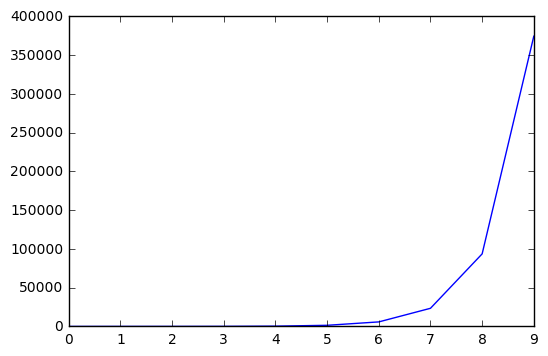

In [197]:
n_points=10
vectors_a = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null() for i in range(n_points)]
vectors_b = [vector.spin(M) for vector in vectors_a]

def update(mot):
    res = np.sum([np.array(resM(a,b,mot)) for a,b in zip(vectors_a, vectors_b)],axis=0)
    grad = np.sum([np.array(dfM(a,b,mot)) for a,b in zip(vectors_a, vectors_b)],axis=0)
    Hess = np.sum([np.array(HessM(a,b,mot)) for a,b in zip(vectors_a, vectors_b)],axis=0)

    B = np.dot(np.linalg.pinv(Hess), grad)
    rot = (vsr.Dll(*B) * mot.rev()).dll().exp() * mot
#     rot = CayE3((vsr.Biv(*B) * rot.rev()).biv()) * rot
    
    grad_norm = np.linalg.norm(grad)
    return rot, res, grad_norm

rot = vsr.Mot(1,0,0,0,0,0,0,0)
ress = []
for i in range(10):
    rot, res, grad_norm = update(rot)
    ress.append(res)
    print(res)
    if res < 1e-6: 
        break
print(i)

plot(ress)

In [171]:
dfM(a,b,M2)

array([-0.299 ,  0.183 ,  0.25  ,  0.134 , -0.2321,  0.2321])

In [156]:
M = vsr.Vec(0,0,1).trs() * vsr.Biv(pi/6,0,0).exp()
a = vsr.Vec(1,0,0).null()
b = a.spin(M)

M2 = vsr.Vec(0,1,0).trs() * vsr.Biv(0,pi/6,0).exp()
HessM(a,b,M2)

CGA: [ 0 0 0 0 0 0 0 0 0 0 0 0 0.87 0 0.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ]


array([[ 3.9641, -0.1495, -2.    , -1.7321,  3.    ,  0.    ],
       [-0.1495,  2.6471,  1.8571, -1.933 , -1.8481,  3.116 ],
       [-2.    ,  1.8571,  1.9641,  0.    , -2.    ,  1.7321],
       [-1.7321, -1.933 ,  0.    ,  4.    ,  0.    ,  0.    ],
       [ 3.    , -1.8481, -2.    ,  0.    ,  2.    ,  0.    ],
       [ 0.    ,  3.116 ,  1.7321,  0.    ,  0.    ,  4.    ]])

In [54]:
def Gi(B,a,b,R):
    G = B.comm(a.spin(R)) * 2
    ans = G * G
    return ans

In [55]:
def Jac(a,R):
    J = np.zeros((3,3))
    for i in range(3):
        Ei = vsr.Biv(0,0,0)
        Ei[i] = 1.0
        J[:,i] = Ei.comm(a.spin(R)) * 2.0
    return J

In [56]:
def Hess2(a,b,rot):
    a = vsr.EGA(a)
    b = vsr.EGA(b)
    R = vsr.EGA(rot)
    E12 = vsr.EGA(vsr.Biv(1,0,0)) * R.rev()
    E13 = vsr.EGA(vsr.Biv(0,1,0)) * R.rev()
    E23 = vsr.EGA(vsr.Biv(0,0,1)) * R.rev()
    E12[0] = 0
    E13[0] = 0
    E23[0] = 0
#     print(E12)
#     print(E13)
#     print(E23)
    H12 = Hi(E12,a,b,R) 
    H13 = Hi(E13,a,b,R)  
    H23 = Hi(E23,a,b,R)  
    H1213 = 0.25 * (Hi(E12+E13,a,b,R) - Hi(E12-E13,a,b,R))
    H1223 = 0.25 * (Hi(E12+E23,a,b,R) - Hi(E12-E23,a,b,R))
    H1323 = 0.25 * (Hi(E13+E23,a,b,R) - Hi(E13-E23,a,b,R))
    return np.array([[  H12[0], H1213[0], H1223[0]],
                     [H1213[0],   H13[0], H1323[0]],
                     [H1223[0], H1323[0],   H23[0]]])

In [57]:
a = vsr.EGA(a)
b = vsr.EGA(b)
R = vsr.EGA(rot)
E12 = vsr.EGA(vsr.Biv(1,0,0))
E13 = vsr.EGA(vsr.Biv(0,1,0)) 
E23 = vsr.EGA(vsr.Biv(0,0,1)) 
0.25 * (Hi(E12+E12,a,b,R) - Hi(E12-E12,a,b,R))

NameError: name 'rot' is not defined

In [58]:
Hi(E12,a,b,R)

NameError: name 'E12' is not defined

In [59]:
a = vsr.Vec(1,0,0)
b = a.spin((vsr.Biv(1,0,0).unit() * (pi/6)).exp())
rot = (vsr.Biv(0,1,0).unit() * (pi/6)).exp()

In [60]:
(a.spin(rot) - b).norm() * (a.spin(rot) - b).norm() 

1.4999999999999998

In [61]:
J = Jac(a,rot)
JtJ = np.dot(J.T,J)
print(JtJ)

[[ 1.      0.     -1.7321]
 [ 0.      4.      0.    ]
 [-1.7321  0.      3.    ]]


In [62]:
print(df(a,b,rot))
print(Hess2(a,b,rot),'\n')

NameError: name 'df' is not defined

In [63]:
print(hyperdual.hyperdualB(a,b,rot)[1][1:])
print(hyperdual.hyperdualB(a,b,rot)[2])

[ 0.866 -0.866 -1.5  ]
[[ 2.5    1.5   -0.866]
 [ 1.5    2.5    0.866]
 [-0.866  0.866  1.5  ]]


In [64]:
print((hyperdual.hyperdualB(a,b,rot)[2] - Hess2(a,b,rot))[0][0])

1.0


In [148]:
def df(a,b,R):
    a = vsr.EGA(a)
    b = vsr.EGA(b)
    R = vsr.EGA(R)
    Rr = R.rev()
    E12 = vsr.EGA(vsr.Biv(1,0,0)) * R.rev()
    E13 = vsr.EGA(vsr.Biv(0,1,0)) * R.rev()
    E23 = vsr.EGA(vsr.Biv(0,0,1)) * R.rev()
    E12[0] = 0
    E13[0] = 0
    E23[0] = 0
    d = lambda Ei : ((a.spin(R) - b) * (2 * Ei.comm(a.spin(R))))[0]
    return np.array([d(E12), d(E13), d(E23)])

In [ ]:
def df(a,b,R):
    a = vsr.EGA(a)
    b = vsr.EGA(b)
    R = vsr.EGA(R)
    Rr = R.rev()
    E12 = vsr.EGA(vsr.Biv(1,0,0)) * R.rev()
    E13 = vsr.EGA(vsr.Biv(0,1,0)) * R.rev()
    E23 = vsr.EGA(vsr.Biv(0,0,1)) * R.rev()
    E12[0] = 0
    E13[0] = 0
    E23[0] = 0
    d = lambda Ei : ((a.spin(R) - b) * (2 * Ei.comm(a.spin(R))))[0]
    return np.array([d(E12), d(E13), d(E23)])

In [93]:
def CayE3(B):
    B = vsr.EGA(B)
    one = vsr.EGA(1.,0.,0.,0.,0.,0.,0.,0.)
    cay = (one + B) * (one - B).inv()
    return -vsr.Rot(cay[0], cay[4], cay[5], cay[6])

In [94]:
CayE3(vsr.Biv(tan(pi/3),0,0))

Rot: [ 0.5 -0.87 -0 -0 ]

7.90173775754
3.80489269296
0.198617857575
1.63616615196e-05
9.03133674098e-18
4


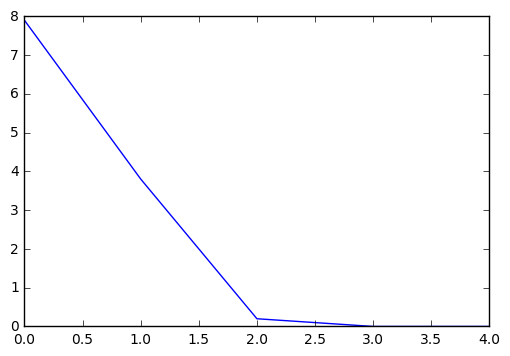

In [103]:
n_points=10
vectors_a = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)) for i in range(n_points)]
vectors_b = [vector.spin(rotor) for vector in vectors_a]

def update(rot):
    ans = [hyperdual.hyperdualB(a,b,rot) for a,b in zip(vectors_a, vectors_b)]
    res = np.sum([t[0] for t in ans])
    
    grad = np.sum([np.array(df(a,b,rot)) for a,b in zip(vectors_a, vectors_b)],axis=0)
    Hess = np.sum([np.array(Hess2(a,b,rot)) for a,b in zip(vectors_a, vectors_b)],axis=0)

    B = np.dot(np.linalg.pinv(Hess), grad)
    rot = (vsr.Biv(*B) * rot.rev()).biv().exp() * rot
#     rot = CayE3((vsr.Biv(*B) * rot.rev()).biv()) * rot
    
    
    grad_norm = np.linalg.norm(grad)
    return rot, res, grad_norm

rot = vsr.Rot(1,0,0,0)
ress = []
for i in range(10):
    rot, res, grad_norm = update(rot)
    ress.append(res)
    print(res)
    if res < 1e-6: 
        break
print(i)

plot(ress)

In [90]:
def grad2(a,b,rot):
    def grad_ij(B, a ,b,rot):
        return (B.comm(a.spin(rot)) * b * -2)[0]
    return vsr.Biv(grad_ij(vsr.Biv(1,0,0),a,b,rot),
                   grad_ij(vsr.Biv(0,1,0),a,b,rot),
                   grad_ij(vsr.Biv(0,0,1),a,b,rot))

In [260]:
a = vsr.Vec(1,0,0)
b = a.spin((vsr.Biv(1,0,0).unit() * (pi/6)).exp())
R = (vsr.Biv(0,1,0).unit() * (pi/6)).exp()

In [261]:
df(a,b,R)

array([ 1.5  , -0.75 , -0.866])

In [262]:
grad2(a,b,R)

Biv: [ 0.866 -0.866 -1.5 ]

In [263]:
hyperdual.hyperdualB(a,b,R)

(0.7499999999999999,
 array([ 0.   ,  0.866, -0.866, -1.5  ]),
 array([[ 2.5  ,  1.5  , -0.866],
        [ 1.5  ,  2.5  ,  0.866],
        [-0.866,  0.866,  1.5  ]]))

In [264]:
a = vsr.EGA(a)
b = vsr.EGA(b)
R = vsr.EGA(R)
ar = a.spin(R)
E12 = vsr.EGA(vsr.Biv(1,0,0))
E13 = vsr.EGA(vsr.Biv(0,1,0))
E23 = vsr.EGA(vsr.Biv(0,0,1))

In [265]:
B1 = E12
B2 = E12

In [266]:
(B1 * B2 * ar * b + 
 B1 * ar * B2.rev() * b + 
 B2* ar * B1.rev() * b +
 ar * B1.rev() * B2.rev() * b) * 0.5

EGA: [ -0.5 0 0 0 -0.87 0 0 0 ]

In [267]:
B1 * (B2 * ar * b - b * ar * B2.rev() * 2.0 + ar.spin(B) * b * 2.0)

EGA: [ 0.12 0 0 0 -0.067 -0.2 3.1 0 ]

In [268]:
a = vsr.Vec(1,0,0)
b = a.spin((vsr.Biv(1,0,0).unit() * (pi/6)).exp())
R = (vsr.Biv(0,1,0).unit() * (pi/6)).exp()

In [269]:

print(Hess2(a,b,R),'\n')
print(hyperdual.hyperdualB(a,b,R)[2])

[[ 1.5    0.75   0.   ]
 [ 0.75   0.75   1.299]
 [ 0.     1.299 -0.5  ]] 

[[ 2.5    1.5   -0.866]
 [ 1.5    2.5    0.866]
 [-0.866  0.866  1.5  ]]


In [270]:
(hyperdual.hyperdualB(a,b,R)[2] + Hess2(a,b,R) ) 

array([[ 4.    ,  2.25  , -0.866 ],
       [ 2.25  ,  3.25  ,  2.1651],
       [-0.866 ,  2.1651,  1.    ]])

In [271]:
H = ans[0][2]
np.dot(np.dot(np.array([1,0,0]).reshape(3,1).T,H),np.array([0,1,0]).reshape(3,1))

array([[ 0.]])

In [272]:
cos(pi/6) - (pi / 9 )

0.51695955338557287

In [273]:
# R = vsr.Biv(0,pi/4,0).exp()
(Hess2(a,b,R).copy()-hyperdual.hyperdualB(a,b,R)[2].copy() )

array([[-1.   , -0.75 ,  0.866],
       [-0.75 , -1.75 ,  0.433],
       [ 0.866,  0.433, -2.   ]])

In [274]:
a.spin(R) <= b

0.2500000000000002

In [275]:
2 * pi /4

1.5707963267948966

In [276]:
cos(pi / 1)

-1.0

In [277]:
print(Hess2(a,b,R).copy()[0,0])
print(hyperdual.hyperdualB(a,b,R)[2].copy()[0,0])

1.5
2.5


In [278]:
ans[0][2]

array([[ 3.    ,  0.    ,  0.    ],
       [ 0.    ,  3.    ,  1.7321],
       [ 0.    ,  1.7321,  1.    ]])

In [279]:
((vsr.Biv(1,2,3).unit() * pi/6).exp() * rotor).rev()

TypeError: unsupported operand type(s) for /: 'versor_pybind11.Biv' and 'int'

In [280]:
rotor.rev() * (vsr.Biv(1,2,3).unit() * pi/6).exp().rev()

TypeError: unsupported operand type(s) for /: 'versor_pybind11.Biv' and 'int'

In [281]:
E = np.array([1,0,0]).reshape(3,1)
np.dot(np.dot(E.T, H2), E)

NameError: name 'H2' is not defined

In [282]:
rotor = (vsr.Biv(1,2,3).unit() * pi/6).exp()
a = vsr.Vec(1,0,0)
b = a.spin(rotor)
rotor1 = vsr.Biv(0,0,pi/6).exp()
_,_,H = hyperdual.hyperdualB(a,b,rotor1)
print(H)

TypeError: unsupported operand type(s) for /: 'versor_pybind11.Biv' and 'int'

In [283]:
Hess2(vsr.EGA(a), vsr.EGA(b), vsr.EGA(rotor1))

NameError: name 'rotor1' is not defined

In [284]:
E12 * cos(pi/6)

EGA: [ 0 0 0 0 0.87 0 0 0 ]

In [285]:
Hij()

TypeError: Hij() missing 5 required positional arguments: 'Bi', 'Bj', 'a', 'b', and 'R'

In [322]:
vectors_a = [vsr.Vec(1,0,0), vsr.Vec(0,1,0), vsr.Vec(0,0,1)]
vectors_b = [a.spin(rotor) for a in vectors_a]

In [307]:
n_points=10
vectors_a = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)) for i in range(n_points)]
vectors_b = [vector.spin(rotor) for vector in vectors_a]

In [288]:
rot = vsr.Rot(1,0,0,0)
np.sum([np.array(Hess2(a,b,rot)) for a,b in zip(vectors_a, vectors_b)],axis=0)

array([[ 23.8533,  -1.199 ,   1.0192],
       [ -1.199 ,  16.685 ,  -8.673 ],
       [  1.0192,  -8.673 ,  32.9391]])

In [289]:
ans = [hyperdual.hyperdualB(a,b,rot) for a,b in zip(vectors_a, vectors_b)]
res = np.sum([t[0] for t in ans])
grad = np.sum([t[1] for t in ans], axis=0)[1:]
Hess = np.sum([t[2] for t in ans], axis=0)
Hess

array([[ 35.78  ,  -1.199 ,   1.0192],
       [ -1.199 ,  28.6117,  -8.673 ],
       [  1.0192,  -8.673 ,  44.8658]])

In [290]:
np.sum([np.array(Hess2(a,b,rot)) for a,b in zip(vectors_a, vectors_b)],axis=0) - Hess

array([[-11.9267,  -0.    ,   0.    ],
       [ -0.    , -11.9267,   0.    ],
       [  0.    ,   0.    , -11.9267]])

In [331]:
def update(rot):
    ans = [hyperdual.hyperdualB(a,b,rot) for a,b in zip(vectors_a, vectors_b)]
    res = np.sum([t[0] for t in ans])
    grad = np.sum([t[1] for t in ans], axis=0)[1:]
    HessD = np.sum([t[2] for t in ans], axis=0)
    
    grad2 = np.sum([np.array(df(a,b,rot)) for a,b in zip(vectors_a, vectors_b)],axis=0)
    HessN = np.sum([np.array(Hess2(a,b,rot)) for a,b in zip(vectors_a, vectors_b)],axis=0)
    
    HessJtJ = np.sum([np.dot(Jac(a,rot).T,Jac(a,rot)) for a,b in zip(vectors_a, vectors_b)],axis=0)
#     print(HessD)
#     print(HessN)

    B = np.dot(np.linalg.pinv(HessN),grad2)
    rot = (vsr.Biv(*B) * rot.rev()).biv().exp() * rot
    
#     B = np.dot(np.linalg.pinv(HessD),grad)
#     rot = vsr.Biv(*B).exp() * rot
    
#     B = np.dot(np.linalg.pinv(HessJtJ),-grad)
#     rot = vsr.Biv(*B).exp() * rot
    
    
    grad_norm = np.linalg.norm(grad)
    return rot, res, grad_norm

In [336]:
rot = vsr.Rot(1,0,0,0)
ress = []
for i in range(10):
    rot, res, grad_norm = update(rot)
    ress.append(res)
    print(res)
    if res < 1e-6: 
        break
print(i)

1.0
0.450976241027
0.0173636623112
5.92424243496e-07
3


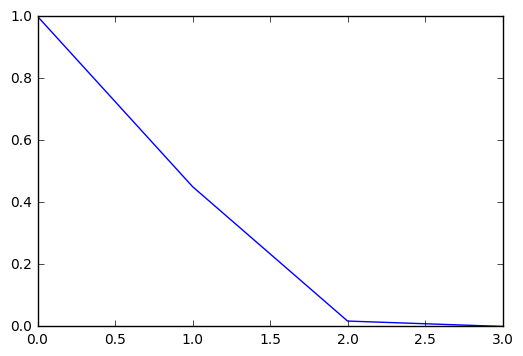

In [337]:
plot(ress)

In [293]:
rot = vsr.Rot(1,0,0,0)
J = np.array([jacrot(a,rot) for a in vectors_a]).reshape(-1,3)
print(np.dot(J.T,J))

NameError: name 'jacrot' is not defined

In [294]:
Hess = np.sum([hyperdual.hyperdualB(a,b,rot)[2] for a,b in zip(vectors_a, vectors_b)], axis=0)
print(Hess)

[[ 35.78    -1.199    1.0192]
 [ -1.199   28.6117  -8.673 ]
 [  1.0192  -8.673   44.8658]]


In [162]:
motor1 = vsr.Mot(1,0,0,0,0,0,0,0)
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
points_a = [a.null() for a in vectors_a]
points_b = [a.spin(motor) for a in points_a]
a = points_a[0]
b = points_b[0]
points_b_noisy = [vsr.Vec(*(np.array(point)[:3] 
                            + sigma * np.random.randn(3))).null() 
                  for point in points_b]

TypeError: unsupported operand type(s) for /: 'versor_pybind11.Biv' and 'float'

In [ ]:
motor0 = vsr.Mot(1,0,0,0,0,0,0,0)
r,g,H = hyperdual.hyperdualmotor(a,b, motor0)
# print(g)
print(H)

In [ ]:
ans = [hyperdual.hyperdualmotor(a,b,motor0) for a,b in zip(points_a, points_b_noisy)]
res = np.sum([t[0] for t in ans])
grad = np.sum([t[1] for t in ans], axis=0)
Hess = np.sum([t[2] for t in ans], axis=0)

In [ ]:
print(grad * -2) 

In [ ]:
vsr.Dll(*grad).spin(motor0)

In [ ]:
print(np.array(motor0 * vsr.Dll(*(np.sum([np.array(vsr.CGA(a.spin(motor0) ^ b) * 2)[6:12]
                        for a, b in zip(points_a, points_b_noisy)], axis=0)) * 2)))

In [ ]:
np.array(vsr.CGA(points_a[0].spin(motor0) ^ points_b[0] ) * 2)[6:16]

In [ ]:
grad * 2

In [ ]:
print(Hess)

In [ ]:
motor.dll()

In [ ]:
scene = Scene(children=
              [point_mesh(point,color=Colors.HOTPINK) for point in points_a] +\
              [point_mesh(point,color=Colors.LIGHTSKYBLUE) for point in points_b] +\
              [line_mesh(vsr.Dll(*grad ))] +\
              [line_mesh(motor.dll())] +\
#               [point_mesh(point,color='palegreen') for point in points_b_noisy] +\
#               [point_mesh(point.spin(motors[1]),color='palegreen') for point in points_a] +\
#               [point_mesh(point.spin(em_point_3_res_noise),color=Colors.HOTPINK) for point in points_a] +\
#             [point_mesh(point.spin(vd_em_points_noise),color=Colors.BLACK) for point in points_a] +\

              [frame_mesh(),AmbientLight(color='#cccccc')])

camera = PerspectiveCamera(position=[3, -3, 3])
renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white',
                    width='960',
                    height='512')
# renderer.width = '1024'
# renderer.height = '768'
display(renderer)

In [ ]:
def update(rot):
    ans = [hyperdual.hyperdualmotor(a,b,rot) for a,b in zip(points_a, points_b)]
    res = np.sum([t[0] for t in ans])
    grad = np.sum([t[1] for t in ans], axis=0)
    Hess = np.sum([t[2] for t in ans], axis=0)
    B = -np.dot(np.linalg.pinv(Hess),grad)
    rot = vsr.Dll(*B).exp() * rot
    grad_norm = np.linalg.norm(grad)
    return rot, res, grad_norm

In [ ]:
M = motor + vsr.Mot(0,2,0,0,0,0,0,0)
M * M.rev()

In [ ]:
M2 = M.retract()
M2 * M2.rev()

In [ ]:
def update2(rot):
    ans = [hyperdual.hyperdualmotor(a,b,rot) for a,b in zip(points_a, points_b)]
    res = np.sum([t[0] for t in ans])
    grad = np.sum([t[1] for t in ans], axis=0)
    Hess = np.sum([t[2] for t in ans], axis=0)
    B = np.dot(np.linalg.pinv(Hess),grad)
    B = vsr.Mot(0,B[0], B[1], B[2], B[3], B[4], B[5], 0)
    rot = (rot * B ).retract()
    grad_norm = np.linalg.norm(grad)
    return rot, res, grad_norm

In [ ]:
rot = vsr.Mot(1,0,0,0,0,0,0,0)
res = 1e6
i = 0
# while res > 1e-6:
for i in range(10):
    i += 1
    rot, res, grad_norm = update(rot)
    print(res)
    print(rot)
# print(i)

In [ ]:
np.linalg.norm(rot.rev() * motor)

In [ ]:
print(rot.rev() * motor)

In [ ]:
import motor_jacobian

In [ ]:
def jacmot(a,mot):
    j = np.zeros((3,6))
    for i in range(6):
        dll = vsr.Dll(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
        dll[i] = 1.0
        j[:,i] = 2. * np.array(dll.comm(a.spin(mot)))[:3]
    return j

In [ ]:
J = np.array([jacmot(a,motor0) for a in points_a]).reshape(-1,6)

In [ ]:
np.dot(J.T,J)

In [ ]:
n_points = 10
sigma = 0.09
points_a = [(vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null(),
             vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null()  )
            for i in range(n_points)]

points_a_noisy = [(vsr.Vec(*(np.array(a)[:3] + sigma * np.random.randn(3))).null(),
                   vsr.Vec(*(np.array(b)[:3] + sigma * np.random.randn(3))).null()) 
                  for a,b in points_a]

lines_a = [vsr.Dll(a,b).unit() for (a,b) in points_a]
lines_b = [line.spin(motor) for line in lines_a]

In [ ]:
def jac(a, mot):
    j = np.zeros((6,6))
    for i in range(6):
        ei = vsr.Dll(0.0, 0.0, 0.0,0.0,0.0,0.0)
        ei[i] = 1.0
        j[:,i] = 2.0 * np.array(ei.comm(a.spin(mot))) # Wrong sign?
    return j

In [ ]:
J = np.array([jac(a, motor0) for a in lines_a]).reshape(-1,6)

In [ ]:
np.dot(J.T,J)

In [ ]:
f = np.array([np.array(a.spin(motor0) - b) for a,b in zip(lines_a, lines_b)]).reshape(-1,1)

In [ ]:
vsr.Dll(*np.dot(J.T,f))

In [ ]:
motor.dll()

In [ ]:
np.sum([np.array(a.spin(motor0).comm(b)) for a,b in zip(lines_a, lines_b)],axis=0)

In [ ]:
lines_a[0].spin(motor).rev()

In [ ]:
lines_a[0].rev().spin(motor)

In [ ]:
l = lines_a[0].spin(motor0) - lines_b[0]
np.inner(l,l)

In [ ]:
np.sum([a*a for a in np.array(l)])

In [ ]:
l * l.rev()

In [ ]:
(l.biv() * l.biv().rev() )[0] + (l.drv().vec() * l.drv().vec().rev())[0]

In [ ]:
Ba = lines_a[0]
Ba[3] = Ba[4] = Ba[5] = 0 
Ba

In [ ]:
da = lines_a[0]
da[0] = da[1] = da[2] = 0
da

In [ ]:
Ba.spin(motor)

In [ ]:
from hyperdual_lines import lines

In [ ]:
lc = np.array(lines_a[0].spin(motor0) - lines_b[0])

In [ ]:
lc[0] * lc[0]

In [ ]:
lines(lines_a[0], lines_b[0], motor0)

In [ ]:
ans = [lines(a,b,motor0) for a,b in zip(lines_a, lines_b)]
res = np.sum([t[0] for t in ans])
grad = np.sum([t[1] for t in ans], axis=0)
Hess = np.sum([t[2] for t in ans], axis=0)
print(grad)

In [ ]:
vsr.Dll(*grad).spin(motor0)

In [ ]:
(motor0 * vsr.Dll(*np.sum([np.array(a.spin(motor0).comm(b)) 
                          for a,b in zip(lines_a, lines_b)],axis=0))).dll()

In [ ]:
vsr.Dll(*np.sum([np.array(a.spin(motor0).comm(b)) 
                          for a,b in zip(lines_a, lines_b)],axis=0))

In [ ]:
n_points = 10
sigma = 0.09
points_a = [(vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null(),
             vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null()  )
            for i in range(n_points)]

points_a_noisy = [(vsr.Vec(*(np.array(a)[:3] + sigma * np.random.randn(3))).null(),
                   vsr.Vec(*(np.array(b)[:3] + sigma * np.random.randn(3))).null()) 
                  for a,b in points_a]

lines_a = [vsr.Dll(a,b).unit() for (a,b) in points_a]
lines_b = [line.spin(motor) for line in lines_a]

In [ ]:
def update(rot):
    ans = [lines(a,b,rot) for a,b in zip(lines_a, lines_b)]
    res = np.sum([t[0] for t in ans])
    grad = np.sum([t[1] for t in ans], axis=0)
    Hess = np.sum([t[2] for t in ans], axis=0)
    B = -np.dot(np.linalg.pinv(Hess),grad)
    rot = vsr.Dll(*B).exp() * rot
    grad_norm = np.linalg.norm(grad)
    return rot, res, grad_norm

In [ ]:
rot = vsr.Mot(1,0,0,0,0,0,0,0)
res = 1e6
i = 0
ress = []
while res > 1e-3:
# for i in range(100):
    i += 1
    rot, res, grad_norm = update(rot)
    ress.append(res)
print(ress)
print(rot)
print(i)

In [ ]:
plot(ress);